<a href="https://colab.research.google.com/github/xli2522/GW-SignalGen/blob/main/modified_S.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img style="float: left;padding: 1.3em" src="https://indico.in2p3.fr/event/18313/logo-786578160.png">  
#  Modified S Transform
#####(for GW Signal Analysis) 
##### © Xiyuan Li 2021, Department of Physics and Astronomy, Western University (UWO), London, Ontario, Canada
##### Resources: 
[PyCBC](http://github.com/ligo-cbc/pycbc) + additional PyCBC [examples](http://pycbc.org/pycbc/latest/html/#library-examples-and-interactive-tutorials) and module level documentation are [here](http://pycbc.org/pycbc/latest/html/py-modindex.html).<br>
[GWpy](https://gwpy.github.io/docs/stable/)
##### Paper Reference:
[Generalizing the inverse FFT of the unit circle, V. Sukhoy, A. Stoytchev, 2019](https://www.nature.com/articles/s41598-019-50234-9)<br>
[THE DISCRETE LINEAR CHIRP TRANSFORM AND ITS APPLICATIONS, O. Alkishriwo, 2013](http://d-scholarship.pitt.edu/17769/3/Alkishriwo_etdPitt2013.pdf)

##### Code Reference:
[gw-odw/odw-2020](http://github.com/gw-odw/odw-2020)<br> 
[Scipy](https://docs.scipy.org/doc/scipy/reference/index.html)<br> 
[Chirp Z Transform](https://github.com/garrettj403/CZT)

## 1 Generate GW Waveforms

### 1.1 Generate Clean BBH Waveforms

In [16]:
# -- Use the following line if running in Google Colab
! pip install -q 'PyCBC==1.15.3' 'lalsuite==6.66'

     |████████████████████████████████| 3.1 MB 34.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 28.5 MB 69 kB/s 
     |████████████████████████████████| 1.6 MB 46.8 MB/s 
     |████████████████████████████████| 1.0 MB 41.9 MB/s 
     |████████████████████████████████| 75 kB 4.3 MB/s 
     |████████████████████████████████| 52 kB 1.1 MB/s 
     |████████████████████████████████| 54 kB 2.6 MB/s 
     |████████████████████████████████| 3.0 MB 38.2 MB/s 


In [17]:
# Initialization
%matplotlib inline

from pycbc.waveform import get_td_waveform
import pylab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as learn
import time
import tqdm    #progress bar

In [18]:
# specify the sample rate ==> the same from above
sample_rate = 4096 # samples per second
#data_length = 1    # seconds

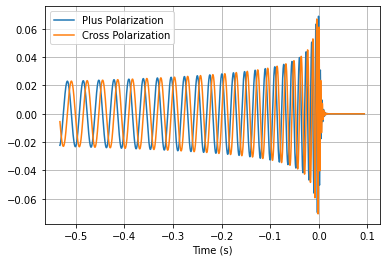

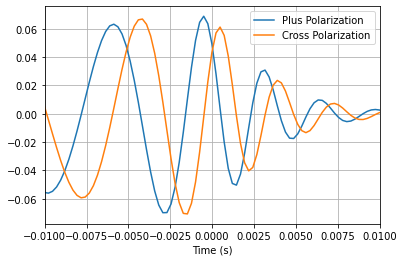

In [19]:
# Generating one example waveform 
# The output of this function are the "plus" and "cross" polarizations of the gravitational-wave signal 
# as viewed from the line of sight at a given source inclination (assumed face-on if not provided)
# https://pycbc.org/pycbc/latest/html/waveform.html

hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=40,
                         mass2=10,
                         delta_t=1.0/sample_rate,
                         f_lower=30,
                         distance=5)

hp = hp / max(np.correlate(hp, hp, mode='full'))**0.5
hc = hc / max(np.correlate(hc, hc, mode='full'))**0.5

pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.grid()
pylab.show()

# Zoom in near the merger time#
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.xlim(-.01, .01)
pylab.legend()
pylab.grid()
pylab.show()

# verify container type and data extraction
testing_container = np.zeros(2, dtype=object)
testing_container[0], testing_container[1] = hp, hc

# hp and hc are clean BBH GW signals

### 1.2 Generate BBH Waveforms with Gaussian Noise

Text(0, 0.5, 'Normalized amplitude')

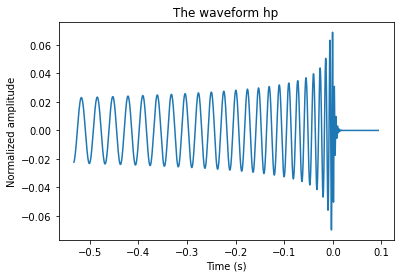

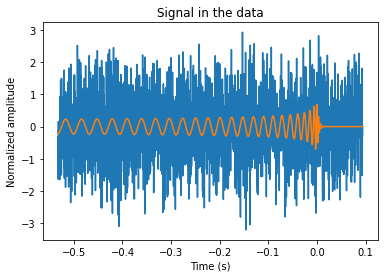

In [20]:
# Generate a long stretch of white noise: the data series and the time series.
data = np.random.normal(size=[len(hp.sample_times)+1])       # size specifies the shape
times = np.arange(len(data)) / float(sample_rate)

# note that in this figure, the waveform amplitude is of order 1.
# The duration (for frequency above f_lower=25 Hz) is only 3 or 4 seconds long.
# The waveform is "tapered": slowly ramped up from zero to full strength, over the first second or so.
# It is zero-padded at earlier times.

# plot the clean signal
pylab.figure()
pylab.title("The waveform hp")
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Normalized amplitude')

# Shift the waveform to start at a random time in the Gaussian noise data.
waveform_start = np.random.randint(0, len(data) - len(hp))

# combine the noise data with *rescaled* clean BBH signal
data[waveform_start:waveform_start+len(hp)] += 10 * hp.numpy()

pylab.figure()
pylab.title("Signal in the data")
pylab.plot(hp.sample_times, data[waveform_start:waveform_start+len(hp)])
pylab.plot(hp.sample_times, 10 * hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Normalized amplitude')

## 2 Spectrograms

#### 2.1 Default STFT Scipy

In [21]:
from scipy import signal as scisignal

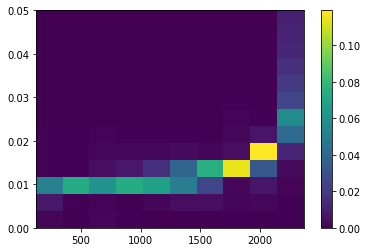

In [22]:
# clean data w/ default spectrogram
freq, ts, Sxx = scisignal.spectrogram(hp)

plt.pcolor(ts, freq, Sxx)		    # plot the spectrogram
plt.ylim(0,0.05)
plt.colorbar()									# colorbar
plt.show()										  # display
plt.close()

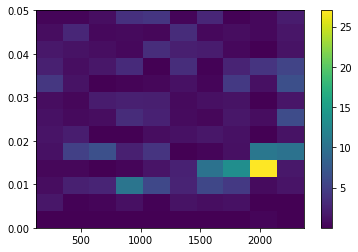

In [23]:
# noisy data w/ default
freq, ts, Sxx = scisignal.spectrogram(data)     # 42 s on colab

plt.pcolor(ts, freq, Sxx)		# plot the spectrogram
plt.ylim(0,0.050)
plt.colorbar()									# colorbar
plt.show()										# display
plt.close()

#### 2.2 Stockwell Transform

##### Main Stockwell Program

In [24]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as scisignal

In [59]:
class signal: 
    '''Generate sample signals'''

    def chirp_signal(dt):
        '''Generate a chirp signal for testing 
        Input
                        dt              the sampling interval
        Output          
                        x               chirp signal 
        '''
        t = np.arange(0,3,dt)
        f0 = 50
        f1 = 250
        t1 = 2
        x = np.cos(2*np.pi*t*(f0 + (f1 - f0)*np.power(t, 2)/(3*t1**2)))
        fs = 1/dt

        return x

class dftMethods:
    '''Distrete Fourier Transform class
    NOTE: could be removed and combined with class TimeFrequency
    '''

    def __init__(self, data, sample_rate, fftmethod='numpy'):
        self.data = data
        self.sample_rate = sample_rate
        self.fftmethod = fftmethod
        self.length = len(data)

class TimeFrequency:
    '''Time-Frequency Analysis Methods class'''

    def __init__(self, ts, sample_rate=4096, frange=None, frate=1, overlap = None, 
                                    nperseg=128, noverlap=64, nfft=800, scaling='spectrum', 
                                                        method = 'dst', show=True, savefig=False):
        '''
        Input
                        ts                  time-domain data
                        sample_rate         sample_rate, the inverse of sample interval
                        L                   the data length included in each DFT
                        frange              the frequency range
                        frate               the frequency sample rate
                        overlap             the length of overlap between DFTs
                        nperseg
                        noverlap
                        nfft 
                        scaling
                        method              spectrogram method - stft/dst/dcst
        '''
        self.ts = ts
        self.sample_rate = sample_rate
        self.frange = frange
        self.frate = frate
        self.overlap = overlap
        self.nperseg = nperseg
        self.noverlap = noverlap
        self.nfft = nfft
        self.scaling = scaling
        self.method = method
        self.show = show
        self.savefig = savefig
        self.length = len(self.ts)
        self.fauto = False
        
        if self.frange == None:
            # use default frange
            self.fauto = True
            self.frange = [0, 500]        # following processes of frange causes y_sticks error
    
    def _window(self, N, nleft=0, nright=0):
        ''' *Planck* Window function
        Imput
                        N               the number of data points included in a window
                        nleft           the number of data points to taper on the left
                        nright          the number of data points to taper on the right
        Return
                        win             the normalized window
        Note: Window scaling factor = 1, normalized
        '''
        from scipy.special import expit

        win = np.ones(N)
        if nleft:
            win[0] *= 0
            zleft = np.array([nleft * (1./k + 1./(k-nleft))
                                for k in range(1, nleft)])
            win[1:nleft] *= expit(-zleft)
        if nright:
            win[N-1] *= 0
            zright = np.array([-nright * (1./(k-nright) + 1./k)
                                for k in range(1, nright)])
            win[N-nright:N-1] *= expit(-zright)

        return win

    def _window_normal(self, freq):
        '''Gaussian Window function
        Input 
                        freq            the number of min frequency bins
        Return
                        win             the normalized gaussian window
        Note: Window scaling factor = 1, normalized
        '''
        gauss = scisignal.gaussian(self.length,std=(freq)/(2*np.pi))
        win = np.hstack((gauss,gauss))[self.length//2:self.length//2+self.length]

        return win

    def stransform(self):
        '''The Stockwell Transform'''
       
        Nfreq = [int(self.frange[0]*self.length/self.sample_rate), int(self.frange[1]*self.length/self.sample_rate)]               # the number of data points for min and max frequencies
        tsVal = np.copy(self.ts)            # copy ts values
        power = np.zeros((int((Nfreq[1]-Nfreq[0])/self.frate)+1,self.length), dtype='c8')            #complex64 C
        tsFFT = np.fft.fft(tsVal)
        vec = np.hstack((tsFFT, tsFFT))
        
        if self.frange[0] == 0:
            power[0] = np.mean(tsVal)*np.ones(self.length)
        else:
            power[0] = np.fft.ifft(vec[Nfreq[0]:Nfreq[0]+self.length]*self._window_normal(Nfreq[0]))
        for i in range(self.frate, (Nfreq[1]-Nfreq[0])+1, self.frate):
            power[int(i/self.frate)] = np.fft.ifft(vec[Nfreq[0]+i:Nfreq[0]+i+self.length]*self._window_normal(Nfreq[0]+i))

        return np.abs(power)

    def get_freq_Hz(self, ks):
        '''Get the frequency label in Hz
        Input
                        ks              the freqeuncy array
        Output
                        ksHz            the frequency array in Hz
        ''' 
        ksHz = ks*self.sample_rate/self.length
        ksHz = [int(i) for i in ksHz]              #to be simplified
          
        return ksHz

    def plot(self):
        '''Generate the spectrogram
        methods: stft / dst / dcst
        '''
        if self.method == 'stft':
            f, t, Sxx = scisignal.spectrogram(
                                self.ts, 
                                self.sample_rate,
                                nperseg=self.nperseg,
                                noverlap=self.noverlap, 
                                nfft=self.nfft, 
                                scaling=self.scaling,
                                window=('tukey', 0.25)
                            )
           
            plt.figure(figsize=(12,9))
            plt.pcolor(t,f, Sxx, cmap ='jet')
            plt.ylabel('Frequency [Hz]')
            plt.xlabel('Time [sec]')
            plt.ylim(0,250)
            plt.colorbar()

        elif self.method == 'dst':

            # s table
            sTable = self.stransform()
            # y axis
            self.fscale = int(self.length/self.sample_rate)
            y_sticksN = 10
            ks = np.linspace(self.frange[0], self.frange[1]*self.fscale, y_sticksN)
            ksHz = self.get_freq_Hz(ks)
            # x axis
            x_sticksN = 10
            ts = np.linspace(0, sTable.shape[1], x_sticksN)
            tsSec = ["{:4.2f}".format(i) for i in np.linspace(0, sTable.shape[1]/self.sample_rate, x_sticksN)]

            extent=(0,sTable.shape[1], self.fscale*self.frange[0], self.fscale*self.frange[1])
    
            plt.figure(figsize=(12,9))
            #plt.imshow(sTable, origin='lower', extent=extent, aspect='auto')           # will be fixed
            plt.imshow(sTable, origin='lower', aspect='auto')
            plt.xticks(ts,tsSec)
            #plt.yticks(ks,ksHz)                             # will be fixed
            if not self.fauto:
                plt.ylim(self.frange[0],self.frange[1])         # will be fixed

            plt.xlabel("Time (sec)")
            plt.ylabel("Freq (Hz)")
            plt.colorbar()
        
        elif self.method == 'dcst':
            pass
        else:
            warnings.warn('Time-Freqeuncy method not supported.')

        if self.show:
            plt.show()
        
        if self.savefig:
            plt.savefig(str(self.method)+str(time.time())+'.png')
        
        return

In [26]:
# inspect the formate of our clean hp data
print(hp)
print(hp.shape)

[-0.02223267 -0.02195683 -0.02163434 ... -0.         -0.
 -0.        ]
(2564,)


##### A Scipy STFT w/ More Details

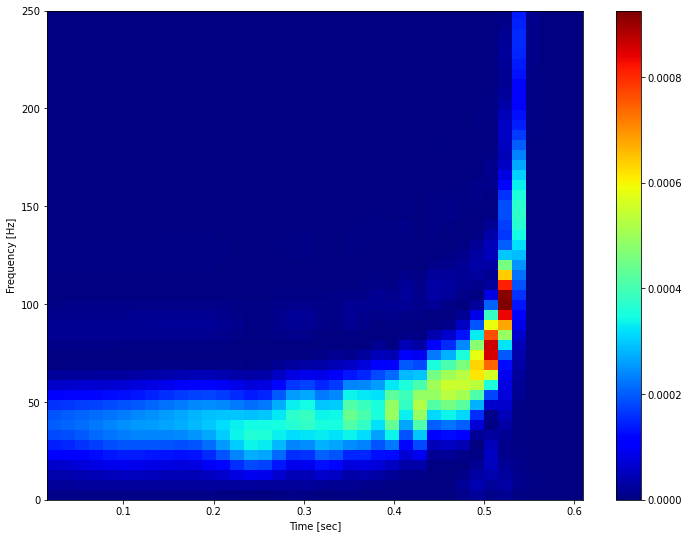

In [27]:
# clean data using STFT through Stockwell Transform code
hpSTFT = TimeFrequency(hp, sample_rate = sample_rate, 
                                              nfft=800, 
                          method='stft', show=True, savefig=False).plot()

In [28]:
# inspect the formate of our noisy data
print(data)
print(data.shape)

[-0.31496602 -1.63794465  0.1616956  ...  0.02514188 -0.27059073
 -2.07890099]
(2565,)


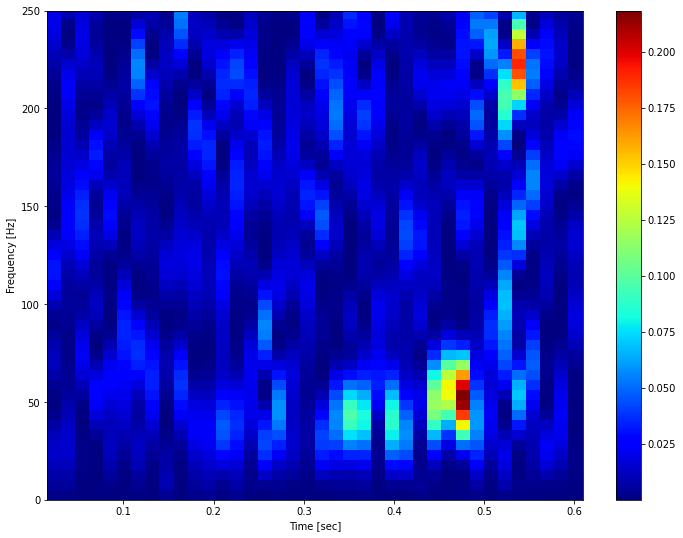

In [29]:
# noisy data using STFT through Stockwell Transform code
hpSTFT = TimeFrequency(data, sample_rate = sample_rate, 
                                                nfft = 800,
                              method='stft', show=True, savefig=False).plot()

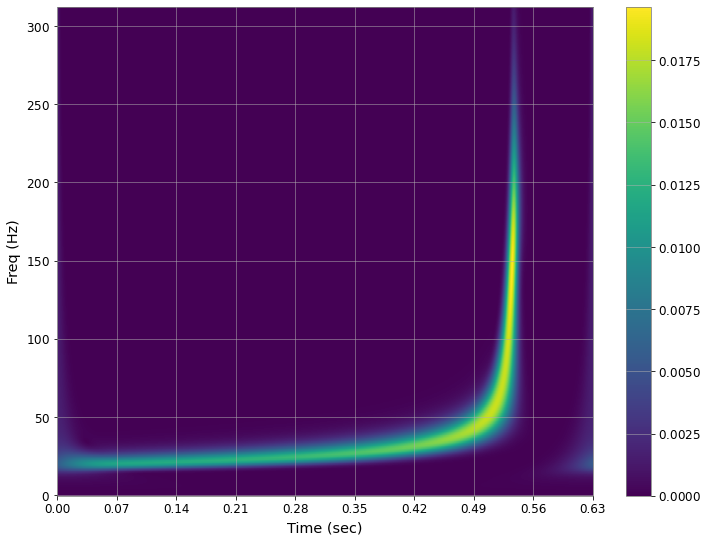

In [50]:
# clean data using ST through Stockwell Transform code
hpST = TimeFrequency(hp, sample_rate = sample_rate, method='dst', show=True, savefig=False).plot()

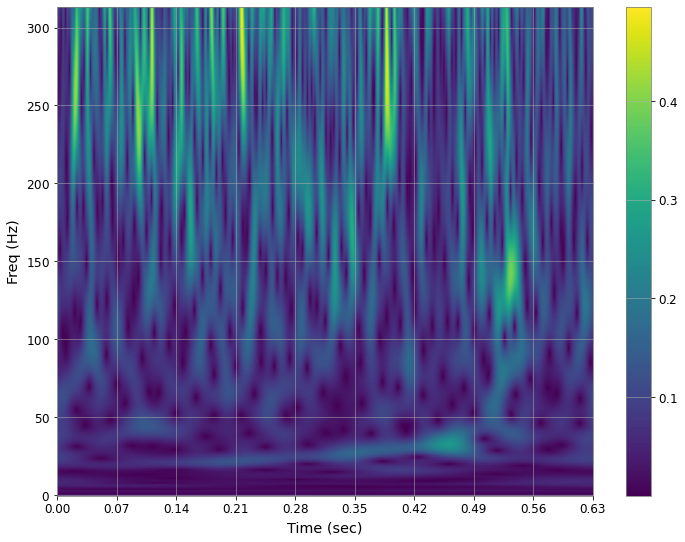

In [51]:
# noisy data using ST through Stockwell Transform code
hpST = TimeFrequency(data, sample_rate = sample_rate, method='dst', show=True, savefig=False).plot()

#### Obtain GW170817 Data

In [32]:
! pip install -q 'gwpy==1.0.1'
from gwpy.timeseries import TimeSeries as GWTimeSeries

     |████████████████████████████████| 1.4 MB 25.7 MB/s 


In [33]:
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries

gps = event_gps('GW170817')
print("GW170817 GPS:", gps)

ldata = TimeSeries.fetch_open_data('L1', int(gps-5), int(gps)+5, cache=True)

# inspect ldata
print("GW170817 data")
print(len(ldata))

GW170817 GPS: 1187008882.4
GW170817 data
40960


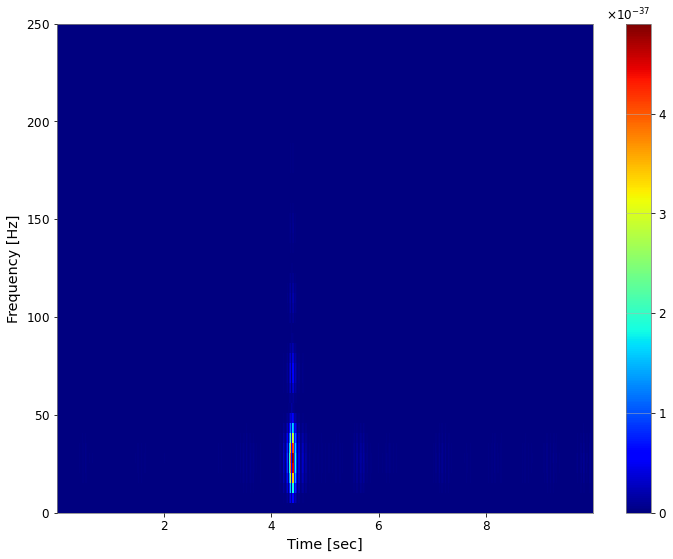

In [34]:
# real noisy data using STFT through Stockwell Transform code
ldataSTFT = TimeFrequency(ldata, sample_rate = sample_rate, 
                                                nfft = 800,
                              method='stft', show=True, savefig=False).plot()

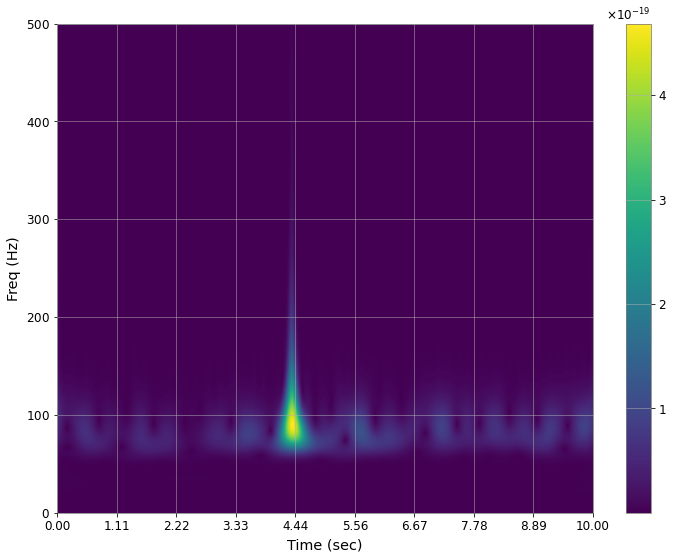

In [35]:
# real noisy data using ST through Stockwell Transform code
ldataST = TimeFrequency(ldata, sample_rate = sample_rate, method='dst', show=True, savefig=False).plot()

## GWpy Constant Q Transform

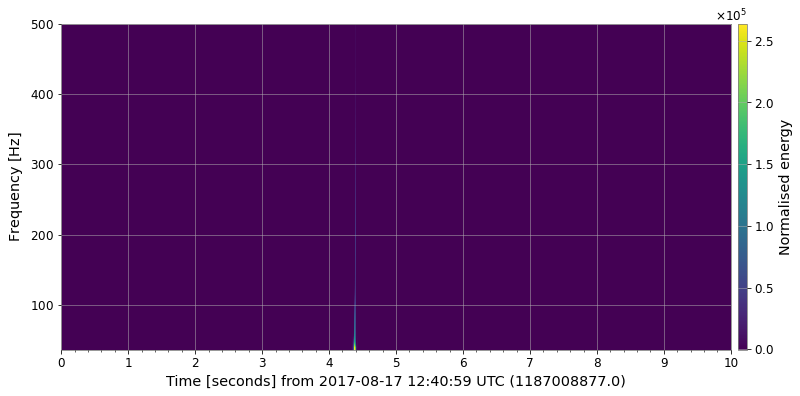

In [36]:
# real noisy data using ST through GWpy CQT
# try pip install constantQ if pip install GWpy gives error locally

hpQ = ldata.q_transform(frange=[0, 500])
plot = hpQ.plot()
plot.colorbar(label="Normalised energy")

## Compare Different Transform Methods

### Generate a short chirp signal

In [37]:
import scipy
from scipy import signal as scisignal
import numpy as np
import matplotlib.pyplot as plt
import time

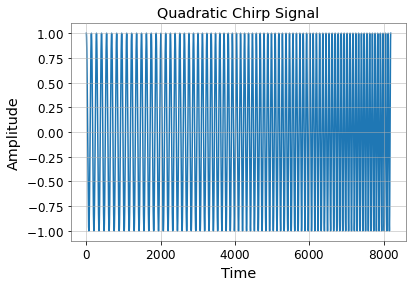

In [38]:
###### Generate a chirp signal ######
# Generate a time array
sample_rate = 4096
tp = 2              # end time
ts = np.linspace(0, tp, sample_rate*tp)

f_range = [30, 60]
chirp = scisignal.chirp(ts, f0=int(f_range[0]), t1=float(ts[-1]), f1=int(f_range[1]), method='quadratic')

# plot the chirp signal
plt.plot(chirp)
plt.title('Quadratic Chirp Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

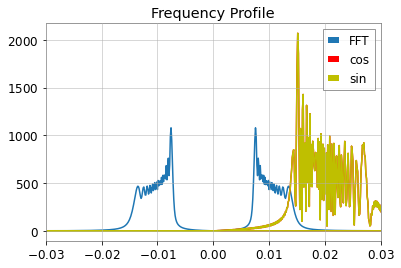

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


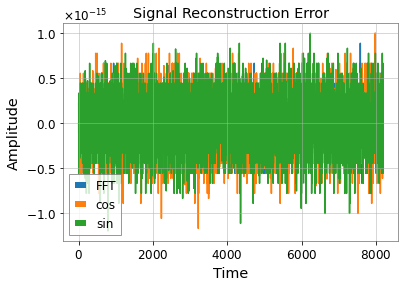

In [39]:
# Numpy FFT
power_fft = np.fft.fft(chirp)
ks_fft = np.fft.fftfreq(sample_rate*tp)[:sample_rate*tp]
ichirp_fft = np.fft.ifft(power_fft)
# Discrete Cosine Transform 
power_cost = scipy.fft.dct(chirp)
ichirp_cost = scipy.fft.idct(power_cost)
# Discrete Sine Transform 
power_sint = scipy.fft.dst(chirp)
ichirp_sint = scipy.fft.idst(power_sint)

# plot FFT
plt.xlim(-0.03, 0.03)
plt.plot(ks_fft, np.abs(power_fft))
# plot Discrete Cosine Transform 
plt.plot(ks_fft, np.abs(power_sint), 'r')
# Plot Discrete Sine Transfrom
plt.plot(ks_fft, np.abs(power_sint), 'y')

plt.title('Frequency Profile')
plt.legend(['FFT', 'cos', 'sin'])
plt.show()

# compare ifft and original ts
plt.plot(chirp - ichirp_fft)
# compare ichirp_cost and original ts
plt.plot(chirp - ichirp_cost)
# compare ichirp_cost and original ts
plt.plot(chirp - ichirp_sint)

plt.title('Signal Reconstruction Error')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend(['FFT', 'cos', 'sin'])
plt.show()

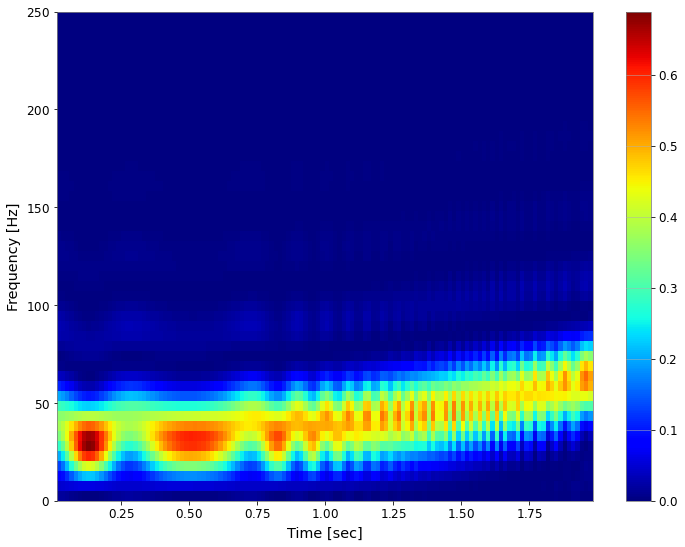

In [41]:
# clean data using STFT through Stockwell Transform code
power_STFT = TimeFrequency(chirp, sample_rate = sample_rate, 
                                              nfft=800, 
                          method='stft', show=True, savefig=False).plot()

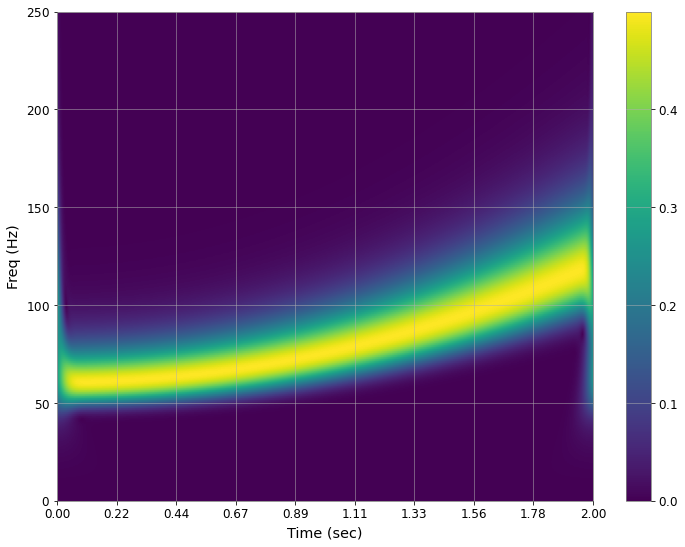

In [61]:
# clean data using ST through Stockwell Transform code
power_stockwell = TimeFrequency(chirp, sample_rate = sample_rate, frange=[0, 250], method='dst', show=True, savefig=False).plot()